In [3]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Variational Distribution #

In [5]:
q = MeanFieldVariationalDistribution(1)

<IPython.core.display.Javascript object>


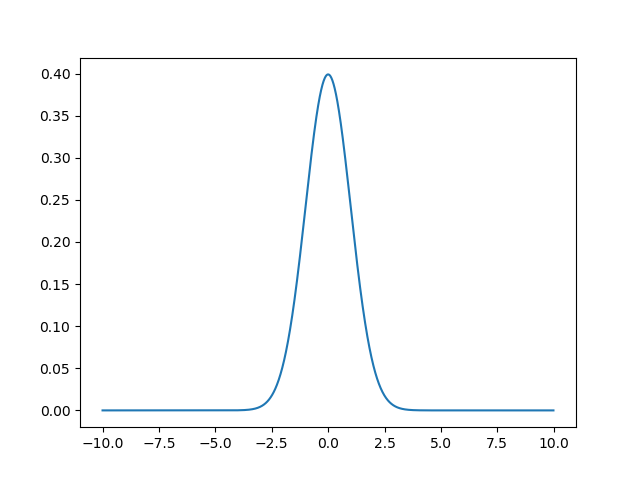

In [6]:
%matplotlib notebook
x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), q.log_prob(x_lin).exp().detach().cpu().numpy())
plt.show()

# Prior #

In [7]:
prior_mu = torch.tensor([0.0])
prior_sigma = torch.tensor([[1.0]])

In [8]:
def prior(x):
    return torch.exp(logprior(x))

def logprior(x):
    return torch.distributions.multivariate_normal.MultivariateNormal(prior_mu, scale_tril=prior_sigma).log_prob(x).unsqueeze(-1)

# Likelihood #

In [9]:
mixture = [torch.distributions.normal.Normal(-5.0, 0.1),
           torch.distributions.normal.Normal(-5.5, 0.2),
           torch.distributions.normal.Normal(-6.0, 0.1)]
proportions = torch.tensor([0.01, 0.19, 0.8])

In [10]:
def likelihood(x):
    return torch.exp(loglikelihood(x))

def loglikelihood(x):
    logp = [None]*len(mixture)
    for j in range(len(mixture)):
        logp[j] = mixture[j].log_prob(x) + proportions[j].log()
    return torch.logsumexp(torch.cat(logp,dim=1),dim=1).unsqueeze(-1)

# Posterior #

In [11]:
def posterior(x):
    return prior(x)*likelihood(x)

In [12]:
def logposterior(x):
    return logprior(x) + loglikelihood(x)

<IPython.core.display.Javascript object>


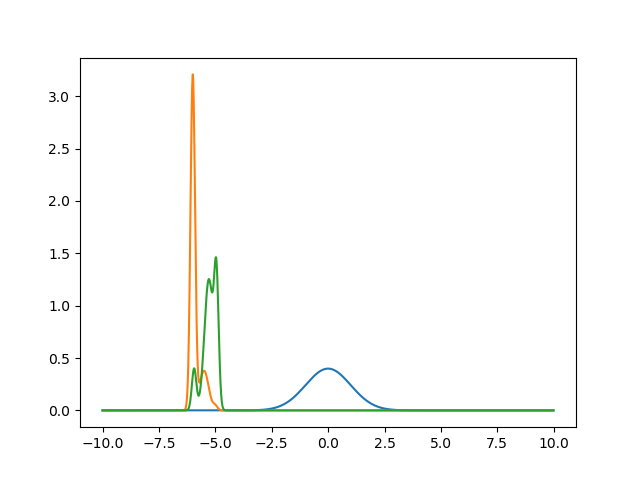

In [13]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), prior(x_lin).detach().cpu().numpy())
plt.plot(x_lin.detach().cpu().numpy(), likelihood(x_lin).detach().cpu().numpy())

Z = (1/(torch.sum(posterior(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*posterior(x_lin).detach().cpu().numpy())
plt.show()

In [14]:
q = MeanFieldVariationalDistribution(1)

In [15]:
n_samples_ELBO = 1

In [16]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=500, factor=0.5)

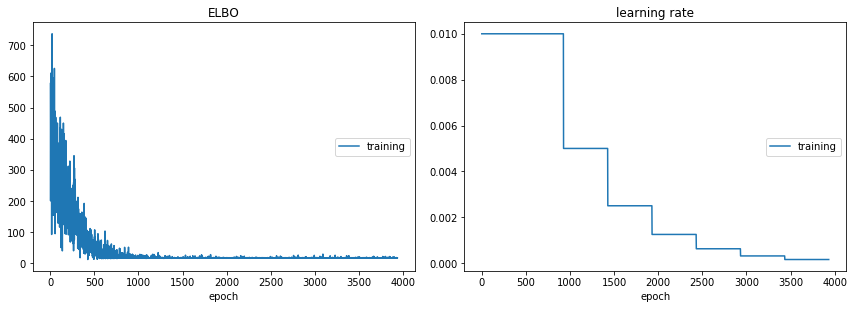

ELBO:
training   (min:   11.582, max:  736.938, cur:   16.651)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [17]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logposterior(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break

<IPython.core.display.Javascript object>


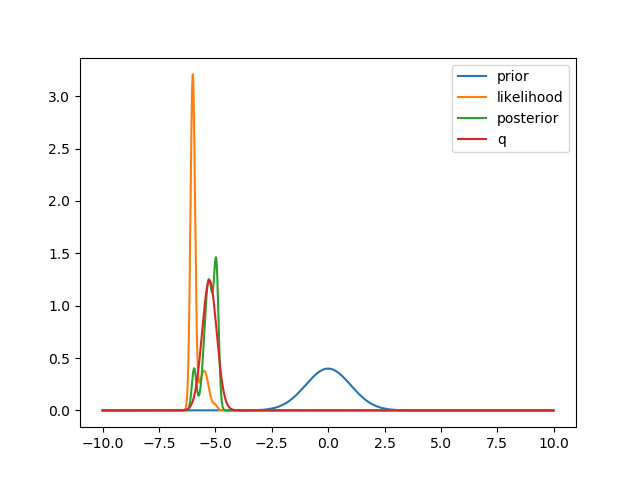

In [20]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)
plt.plot(x_lin.detach().cpu().numpy(), prior(x_lin).detach().cpu().numpy())
plt.plot(x_lin.detach().cpu().numpy(), likelihood(x_lin).detach().cpu().numpy())

Z = (1/(torch.sum(posterior(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*posterior(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.legend(['prior', 'likelihood', 'posterior', 'q'])
plt.show()

<IPython.core.display.Javascript object>


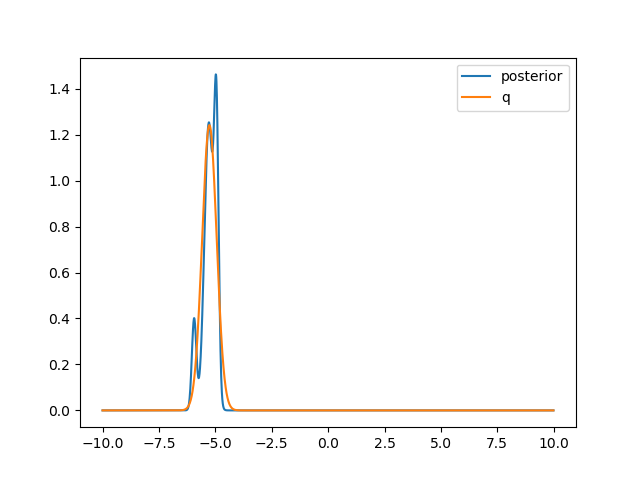

In [21]:
%matplotlib notebook
%matplotlib notebook

x_lin = torch.arange(-10, 10.0, 0.01).unsqueeze(-1)

Z = (1/(torch.sum(posterior(x_lin),dim=0)*0.01)).detach().cpu().numpy()
plt.plot(x_lin.detach().cpu().numpy(), Z*posterior(x_lin).detach().cpu().numpy())

plt.plot(x_lin.detach().numpy(), q.log_prob(x_lin).exp().detach().numpy())
plt.legend(['posterior', 'q'])
plt.show()